# LinkNYC Kiosk Analysis by Census Tract

This notebook analyzes LinkNYC kiosk data at the census tract level, providing detailed geographic insights and aggregate statistics for urban infrastructure planning.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("Set2")
%matplotlib inline

In [2]:
# Load the LinkNYC kiosk data
print("Loading LinkNYC kiosk data...")
kiosk_data = pd.read_csv('../data/linknyc_kiosk_status_20250924.csv')
kiosk_data.columns = kiosk_data.columns.str.strip()

# Convert date columns
date_cols = ['GENERATED ON', 'INSTALLATION DATE', 'ACTIVATION DATE', 'WIFI LAST TS']
for col in date_cols:
    if col in kiosk_data.columns:
        kiosk_data[col] = pd.to_datetime(kiosk_data[col], errors='coerce')

print(f"✓ Loaded {len(kiosk_data):,} kiosk records")
print(f"✓ Data generated: {kiosk_data['GENERATED ON'].iloc[0].strftime('%Y-%m-%d %H:%M')}")
kiosk_data.head()

Loading LinkNYC kiosk data...
✓ Loaded 2,308 kiosk records
✓ Data generated: 2025-01-15 11:00


,GENERATED ON,SITE ID,STATUS,Planned Kiosk Type,PPT ID,ADDRESS,CITY,STATE,POSTCODE,BOROUGH,...,BIN,INSTALLATION DATE,ACTIVATION DATE,WIFI STATUS,WIFI LAST TS,TABLET STATUS,TABLET LAST TS,PHONE STATUS,DIALER LAST TS,LOCATION
0,2025-01-15 11:00:00.381,qu-03-gf44819,Activation,Link 5G,GF44819,75-20 ASTORIA BOULEVARD,Queens,NY,11370,Queens,...,4307280.0,2024-09-04 20:00:00,NaT,NaN,NaT,NaN,NaN,NaN,NaN,"(40.7642912, -73.8948328)"
1,2024-09-26 11:00:00.475,bx-06-146096,Repair,Link 1.0,146096,4201 3 AVENUE,Bronx,NY,10457,Bronx,...,2009606.0,2018-06-19 20:00:00,2018-07-25 20:00:00,up,2024-09-26 11:00:00.475,NaN,NaN,NaN,NaN,"(40.84647676, -73.89639316)"
2,2024-03-13 09:00:00.978,bk-01-gf34839,Installed,Link 5G,GF34839,135 HAVEMEYER STREET,Brooklyn,NY,11211,Brooklyn,...,NaN,2023-05-03 20:00:00,NaT,NaN,NaT,NaN,NaN,NaN,NaN,"(40.712112, -73.9571476)"
3,2024-05-24 09:00:00.683,bk-16-gf34731,Installed,Link 1.0,GF34731,121 LIBERTY AVENUE,Brooklyn,NY,11212,Brooklyn,...,3405082.0,2024-05-12 20:00:00,NaT,NaN,NaT,NaN,NaN,NaN,NaN,"(40.6732003, -73.9058603)"
4,2024-01-24 10:00:00.747,mn-12-gf0841,Installed,Link 1.0,GF0841,4119 BROADWAY,Manhattan,NY,10033,Manhattan,...,NaN,2023-12-03 19:00:00,NaT,NaN,NaT,NaN,NaN,NaN,NaN,"(40.8455391, -73.9388995)"


## Load Census Tract Boundaries

In [3]:
# Load NYC census tract boundaries from the existing shapefile
print("Loading NYC census tract boundaries...")

# Use the census block shapefile we already have and dissolve to tract level
census_blocks_path = "../res/tl_2024_36_tabblock20/tl_2024_36_tabblock20.shp"

try:
    # Load census blocks
    blocks_gdf = gpd.read_file(census_blocks_path)
    print(f"✓ Loaded {len(blocks_gdf):,} census blocks")
    
    # Filter to NYC counties (5 boroughs)
    NYC_COUNTY_FIPS = ['061', '047', '081', '005', '085']  # Manhattan, Brooklyn, Queens, Bronx, Staten Island
    nyc_blocks = blocks_gdf[blocks_gdf['COUNTYFP20'].isin(NYC_COUNTY_FIPS)].copy()
    print(f"✓ Filtered to {len(nyc_blocks):,} NYC census blocks")
    
    # Create tract GEOID from block GEOID (first 11 digits)
    nyc_blocks['TRACT_GEOID'] = nyc_blocks['GEOID20'].str[:11]
    
    # Dissolve blocks into tracts
    print("Dissolving blocks into census tracts...")
    census_tracts = nyc_blocks.dissolve(
        by='TRACT_GEOID', 
        aggfunc={
            'ALAND20': 'sum',    # Sum land areas
            'AWATER20': 'sum',   # Sum water areas  
            'POP20': 'sum',      # Sum population
            'COUNTYFP20': 'first' # Keep county info
        }
    ).reset_index()
    
    # Add borough names
    COUNTY_TO_BOROUGH = {
        '061': 'MANHATTAN',
        '047': 'BROOKLYN', 
        '081': 'QUEENS',
        '005': 'BRONX',
        '085': 'STATEN ISLAND'
    }
    census_tracts['BOROUGH'] = census_tracts['COUNTYFP20'].map(COUNTY_TO_BOROUGH)
    
    # Calculate tract characteristics
    census_tracts['LAND_AREA_SQMI'] = census_tracts['ALAND20'] / 2589988.11  # Convert to square miles
    census_tracts['POPULATION_DENSITY'] = census_tracts['POP20'] / census_tracts['LAND_AREA_SQMI']
    
    # Ensure proper CRS for spatial operations
    census_tracts = census_tracts.to_crs('EPSG:4326')
    
    print(f"✓ Created {len(census_tracts):,} census tracts for NYC")
    print(f"Census tracts by borough:")
    print(census_tracts.groupby('BOROUGH').size())
    
except Exception as e:
    print(f"✗ Error loading census tract data: {e}")
    census_tracts = None

Loading NYC census tract boundaries...
✓ Loaded 288,819 census blocks
✓ Filtered to 37,984 NYC census blocks
Dissolving blocks into census tracts...
✓ Created 2,327 census tracts for NYC
Census tracts by borough:
BOROUGH
BRONX            361
BROOKLYN         805
MANHATTAN        310
QUEENS           725
STATEN ISLAND    126
dtype: int64


## Prepare Kiosk Geographic Data

In [4]:
# Filter kiosks with valid coordinates
print("Preparing kiosk geographic data...")

kiosks_with_coords = kiosk_data[['LATITUDE', 'LONGITUDE', 'BOROUGH', 'STATUS', 'COMMUNITY BOARD', 
                                'Planned Kiosk Type', 'INSTALLATION DATE', 'ACTIVATION DATE']].dropna(
    subset=['LATITUDE', 'LONGITUDE']
).copy()

print(f"✓ Found {len(kiosks_with_coords):,} kiosks with valid coordinates")

# Create GeoDataFrame from kiosk coordinates
kiosks_gdf = gpd.GeoDataFrame(
    kiosks_with_coords,
    geometry=[Point(xy) for xy in zip(kiosks_with_coords['LONGITUDE'], kiosks_with_coords['LATITUDE'])],
    crs='EPSG:4326'
)

print(f"✓ Created GeoDataFrame with {len(kiosks_gdf):,} kiosk locations")

# Basic statistics
print(f"\nKiosk distribution by borough:")
borough_counts = kiosks_gdf['BOROUGH'].value_counts()
for borough, count in borough_counts.items():
    pct = (count / len(kiosks_gdf)) * 100
    print(f"• {borough}: {count:,} ({pct:.1f}%)")

print(f"\nKiosk status distribution:")
status_counts = kiosks_gdf['STATUS'].value_counts()
for status, count in status_counts.items():
    pct = (count / len(kiosks_gdf)) * 100
    print(f"• {status}: {count:,} ({pct:.1f}%)")

Preparing kiosk geographic data...
✓ Found 2,308 kiosks with valid coordinates
✓ Created GeoDataFrame with 2,308 kiosk locations

Kiosk distribution by borough:
• Manhattan: 1,223 (53.0%)
• Queens: 430 (18.6%)
• Brooklyn: 383 (16.6%)
• Bronx: 222 (9.6%)
• Staten Island: 50 (2.2%)

Kiosk status distribution:
• Live: 2,206 (95.6%)
• Installed: 68 (2.9%)
• Repair: 28 (1.2%)
• Activation: 6 (0.3%)


## Spatial Join: Map Kiosks to Census Tracts

In [5]:
# Perform spatial join to assign kiosks to census tracts
if census_tracts is not None:
    print("Performing spatial join: kiosks → census tracts...")
    
    # Spatial join
    kiosks_with_tracts = gpd.sjoin(
        kiosks_gdf, 
        census_tracts[['TRACT_GEOID', 'BOROUGH', 'ALAND20', 'POP20', 'LAND_AREA_SQMI', 'geometry']], 
        how='left', 
        predicate='within'
    )
    
    # Check for kiosks that didn't match to any tract
    unmatched = kiosks_with_tracts['TRACT_GEOID'].isna().sum()
    matched = len(kiosks_with_tracts) - unmatched
    
    print(f"✓ Spatial join completed:")
    print(f"  • {matched:,} kiosks matched to census tracts ({matched/len(kiosks_with_tracts)*100:.1f}%)")
    print(f"  • {unmatched:,} kiosks unmatched ({unmatched/len(kiosks_with_tracts)*100:.1f}%)")
    
    # Remove unmatched kiosks for clean analysis
    kiosks_with_tracts = kiosks_with_tracts.dropna(subset=['TRACT_GEOID'])
    print(f"✓ Using {len(kiosks_with_tracts):,} kiosks with tract assignments")
    
else:
    print("✗ Census tract data not available")
    kiosks_with_tracts = None

Performing spatial join: kiosks → census tracts...
✓ Spatial join completed:
  • 2,308 kiosks matched to census tracts (100.0%)
  • 0 kiosks unmatched (0.0%)
✓ Using 2,308 kiosks with tract assignments


## Generate Census Tract Level Statistics

In [ ]:
if kiosks_with_tracts is not None:
    print("Generating census tract level statistics...")

    # Aggregate kiosk data by census tract
    # Get all unique planned kiosk types
    kiosk_types = kiosks_with_tracts['Planned Kiosk Type'].unique()

    # Aggregate kiosk data by census tract, including counts for each kiosk type
    tract_stats = kiosks_with_tracts.groupby('TRACT_GEOID').agg(
        total_kiosks=('STATUS', 'count'),
        live_kiosks=('STATUS', lambda x: (x == 'Live').sum()),
        borough=('BOROUGH_left', 'first'),
        primary_kiosk_type=('Planned Kiosk Type', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'),
        first_install=('INSTALLATION DATE', 'min'),
        latest_install=('INSTALLATION DATE', 'max'),
        community_boards=('COMMUNITY BOARD', 'nunique'),
        **{f"{kt}_count": ('Planned Kiosk Type', lambda x, kt=kt: (x == kt).sum()) for kt in kiosk_types}
    ).round(2)
    
    # Flatten column names
    tract_stats.columns = ['total_kiosks', 'live_kiosks', 'borough', 'primary_kiosk_type', 
                          'first_install', 'latest_install', 'community_boards'] + \
                            [f"{kt.replace(" ","_").replace(".0","").lower()}_count" for kt in kiosk_types]
    
    # Calculate derived metrics
    tract_stats['live_percentage'] = (tract_stats['live_kiosks'] / tract_stats['total_kiosks'] * 100).round(1)
    tract_stats['not_live_kiosks'] = tract_stats['total_kiosks'] - tract_stats['live_kiosks']
    
    # Merge with census tract geographic and demographic data
    tract_analysis = census_tracts[['TRACT_GEOID', 'BOROUGH', 'ALAND20', 'AWATER20', 'POP20', 
                                   'LAND_AREA_SQMI', 'POPULATION_DENSITY', 'geometry']].merge(
        tract_stats.reset_index(), 
        on='TRACT_GEOID', 
        how='left'
    )
    
    # Fill NaN values for tracts without kiosks
    kiosk_cols = ['total_kiosks', 'live_kiosks', 'not_live_kiosks', 'community_boards']
    for col in kiosk_cols:
        tract_analysis[col] = tract_analysis[col].fillna(0).astype(int)
    
    tract_analysis['live_percentage'] = tract_analysis['live_percentage'].fillna(0)
    tract_analysis['primary_kiosk_type'] = tract_analysis['primary_kiosk_type'].fillna('None')
    
    # Calculate kiosk density metrics
    tract_analysis['kiosks_per_sqmi'] = (tract_analysis['total_kiosks'] / tract_analysis['LAND_AREA_SQMI']).round(2)
    tract_analysis['kiosks_per_1000_pop'] = np.where(
        tract_analysis['POP20'] > 0,
        (tract_analysis['total_kiosks'] / tract_analysis['POP20'] * 1000).round(2),
        0
    )
    
    print(f"✓ Generated statistics for {len(tract_analysis):,} census tracts")
    print(f"✓ {len(tract_analysis[tract_analysis['total_kiosks'] > 0]):,} tracts have kiosks")
    
    # Summary by borough
    print(f"\nCensus tract summary by borough:")
    borough_summary = tract_analysis.groupby('BOROUGH').agg({
        'TRACT_GEOID': 'count',
        'total_kiosks': ['sum', 'mean'],
        'live_kiosks': 'sum',
        'POP20': 'sum',
        'LAND_AREA_SQMI': 'sum'
    }).round(2)
    
    borough_summary.columns = ['num_tracts', 'total_kiosks', 'avg_kiosks_per_tract', 
                              'total_live_kiosks', 'total_population', 'total_area_sqmi']
    
    for borough in borough_summary.index:
        data = borough_summary.loc[borough]
        live_pct = (data['total_live_kiosks'] / data['total_kiosks'] * 100) if data['total_kiosks'] > 0 else 0
        kiosks_per_sqmi = data['total_kiosks'] / data['total_area_sqmi']
        print(f"• {borough}:")
        print(f"  - {data['num_tracts']:.0f} tracts, {data['total_kiosks']:.0f} kiosks ({data['avg_kiosks_per_tract']:.1f} avg/tract)")
        print(f"  - {live_pct:.1f}% live, {kiosks_per_sqmi:.1f} kiosks/sq mi")
    
else:
    print("✗ Cannot generate tract statistics without spatial join data")
    tract_analysis = None

print(tract_analysis.head())

Generating census tract level statistics...
✓ Generated statistics for 2,327 census tracts
✓ 671 tracts have kiosks

Census tract summary by borough:
• BRONX:
  - 361 tracts, 222 kiosks (0.6 avg/tract)
  - 95.5% live, 5.3 kiosks/sq mi
• BROOKLYN:
  - 805 tracts, 383 kiosks (0.5 avg/tract)
  - 91.4% live, 5.5 kiosks/sq mi
• MANHATTAN:
  - 310 tracts, 1223 kiosks (4.0 avg/tract)
  - 98.1% live, 54.0 kiosks/sq mi
• QUEENS:
  - 725 tracts, 430 kiosks (0.6 avg/tract)
  - 91.9% live, 4.0 kiosks/sq mi
• STATEN ISLAND:
  - 126 tracts, 50 kiosks (0.4 avg/tract)
  - 98.0% live, 0.9 kiosks/sq mi
   TRACT_GEOID BOROUGH  ALAND20  AWATER20  POP20  LAND_AREA_SQMI  \
0  36005000100   BRONX  1677210   1035011   3772        0.647574   
1  36005000200   BRONX   452832    852406   4779        0.174839   
2  36005000400   BRONX   770689    690794   6272        0.297565   
3  36005001600   BRONX   485078         0   5795        0.187290   
4  36005001901   BRONX   205007         0   2292        0.079154   


## Top Performing Census Tracts

In [7]:
if tract_analysis is not None:
    print("Analyzing top performing census tracts...")
    
    # Top tracts by total kiosk count
    top_kiosk_tracts = tract_analysis.nlargest(10, 'total_kiosks')[[
        'TRACT_GEOID', 'BOROUGH', 'total_kiosks', 'live_kiosks', 'live_percentage',
        'POP20', 'kiosks_per_sqmi', 'kiosks_per_1000_pop'
    ]]
    
    print(f"\nTop 10 Census Tracts by Total Kiosks:")
    print("─" * 80)
    for _, tract in top_kiosk_tracts.iterrows():
        print(f"{tract['TRACT_GEOID']} ({tract['BOROUGH']}):")
        print(f"  • {tract['total_kiosks']} kiosks ({tract['live_kiosks']} live, {tract['live_percentage']}%)")
        print(f"  • {tract['kiosks_per_sqmi']:.1f} kiosks/sq mi, {tract['kiosks_per_1000_pop']:.2f} per 1K pop")
        print()
    
    # Top tracts by kiosk density (per square mile)
    density_tracts = tract_analysis[tract_analysis['total_kiosks'] > 0].nlargest(10, 'kiosks_per_sqmi')[[
        'TRACT_GEOID', 'BOROUGH', 'total_kiosks', 'live_percentage',
        'LAND_AREA_SQMI', 'kiosks_per_sqmi', 'POPULATION_DENSITY'
    ]]
    
    print(f"\nTop 10 Census Tracts by Kiosk Density:")
    print("─" * 80)
    for _, tract in density_tracts.iterrows():
        print(f"{tract['TRACT_GEOID']} ({tract['BOROUGH']}):")
        print(f"  • {tract['kiosks_per_sqmi']:.1f} kiosks/sq mi ({tract['total_kiosks']} total)")
        print(f"  • {tract['LAND_AREA_SQMI']:.2f} sq mi area, {tract['POPULATION_DENSITY']:.0f} people/sq mi")
        print()
    
    # High performance tracts (high count + high operational rate)
    performance_tracts = tract_analysis[
        (tract_analysis['total_kiosks'] >= 5) & 
        (tract_analysis['live_percentage'] >= 90)
    ].sort_values('total_kiosks', ascending=False)[[
        'TRACT_GEOID', 'BOROUGH', 'total_kiosks', 'live_kiosks', 'live_percentage'
    ]]
    
    print(f"\nHigh Performance Tracts (≥5 kiosks, ≥90% operational):")
    print("─" * 60)
    if len(performance_tracts) > 0:
        for _, tract in performance_tracts.head(10).iterrows():
            print(f"{tract['TRACT_GEOID']} ({tract['BOROUGH']}): {tract['total_kiosks']} kiosks, {tract['live_percentage']}% live")
    else:
        print("No tracts meet high performance criteria")

Analyzing top performing census tracts...

Top 10 Census Tracts by Total Kiosks:
────────────────────────────────────────────────────────────────────────────────
36061006600 (MANHATTAN):
  • 21 kiosks (20 live, 95.2%)
  • 311.3 kiosks/sq mi, 1.70 per 1K pop

36061007200 (MANHATTAN):
  • 20 kiosks (20 live, 100.0%)
  • 296.0 kiosks/sq mi, 2.14 per 1K pop

36061008100 (MANHATTAN):
  • 18 kiosks (18 live, 100.0%)
  • 267.5 kiosks/sq mi, 2.29 per 1K pop

36061015302 (MANHATTAN):
  • 18 kiosks (18 live, 100.0%)
  • 533.9 kiosks/sq mi, 2.98 per 1K pop

36061018700 (MANHATTAN):
  • 18 kiosks (18 live, 100.0%)
  • 213.7 kiosks/sq mi, 1.92 per 1K pop

36061008800 (MANHATTAN):
  • 17 kiosks (17 live, 100.0%)
  • 245.6 kiosks/sq mi, 1.92 per 1K pop

36061007400 (MANHATTAN):
  • 15 kiosks (15 live, 100.0%)
  • 223.2 kiosks/sq mi, 2.63 per 1K pop

36061012500 (MANHATTAN):
  • 15 kiosks (15 live, 100.0%)
  • 222.9 kiosks/sq mi, 5.17 per 1K pop

36061013700 (MANHATTAN):
  • 15 kiosks (14 live, 93.3%)

## Visualizations: Census Tract Analysis

Creating census tract visualizations...


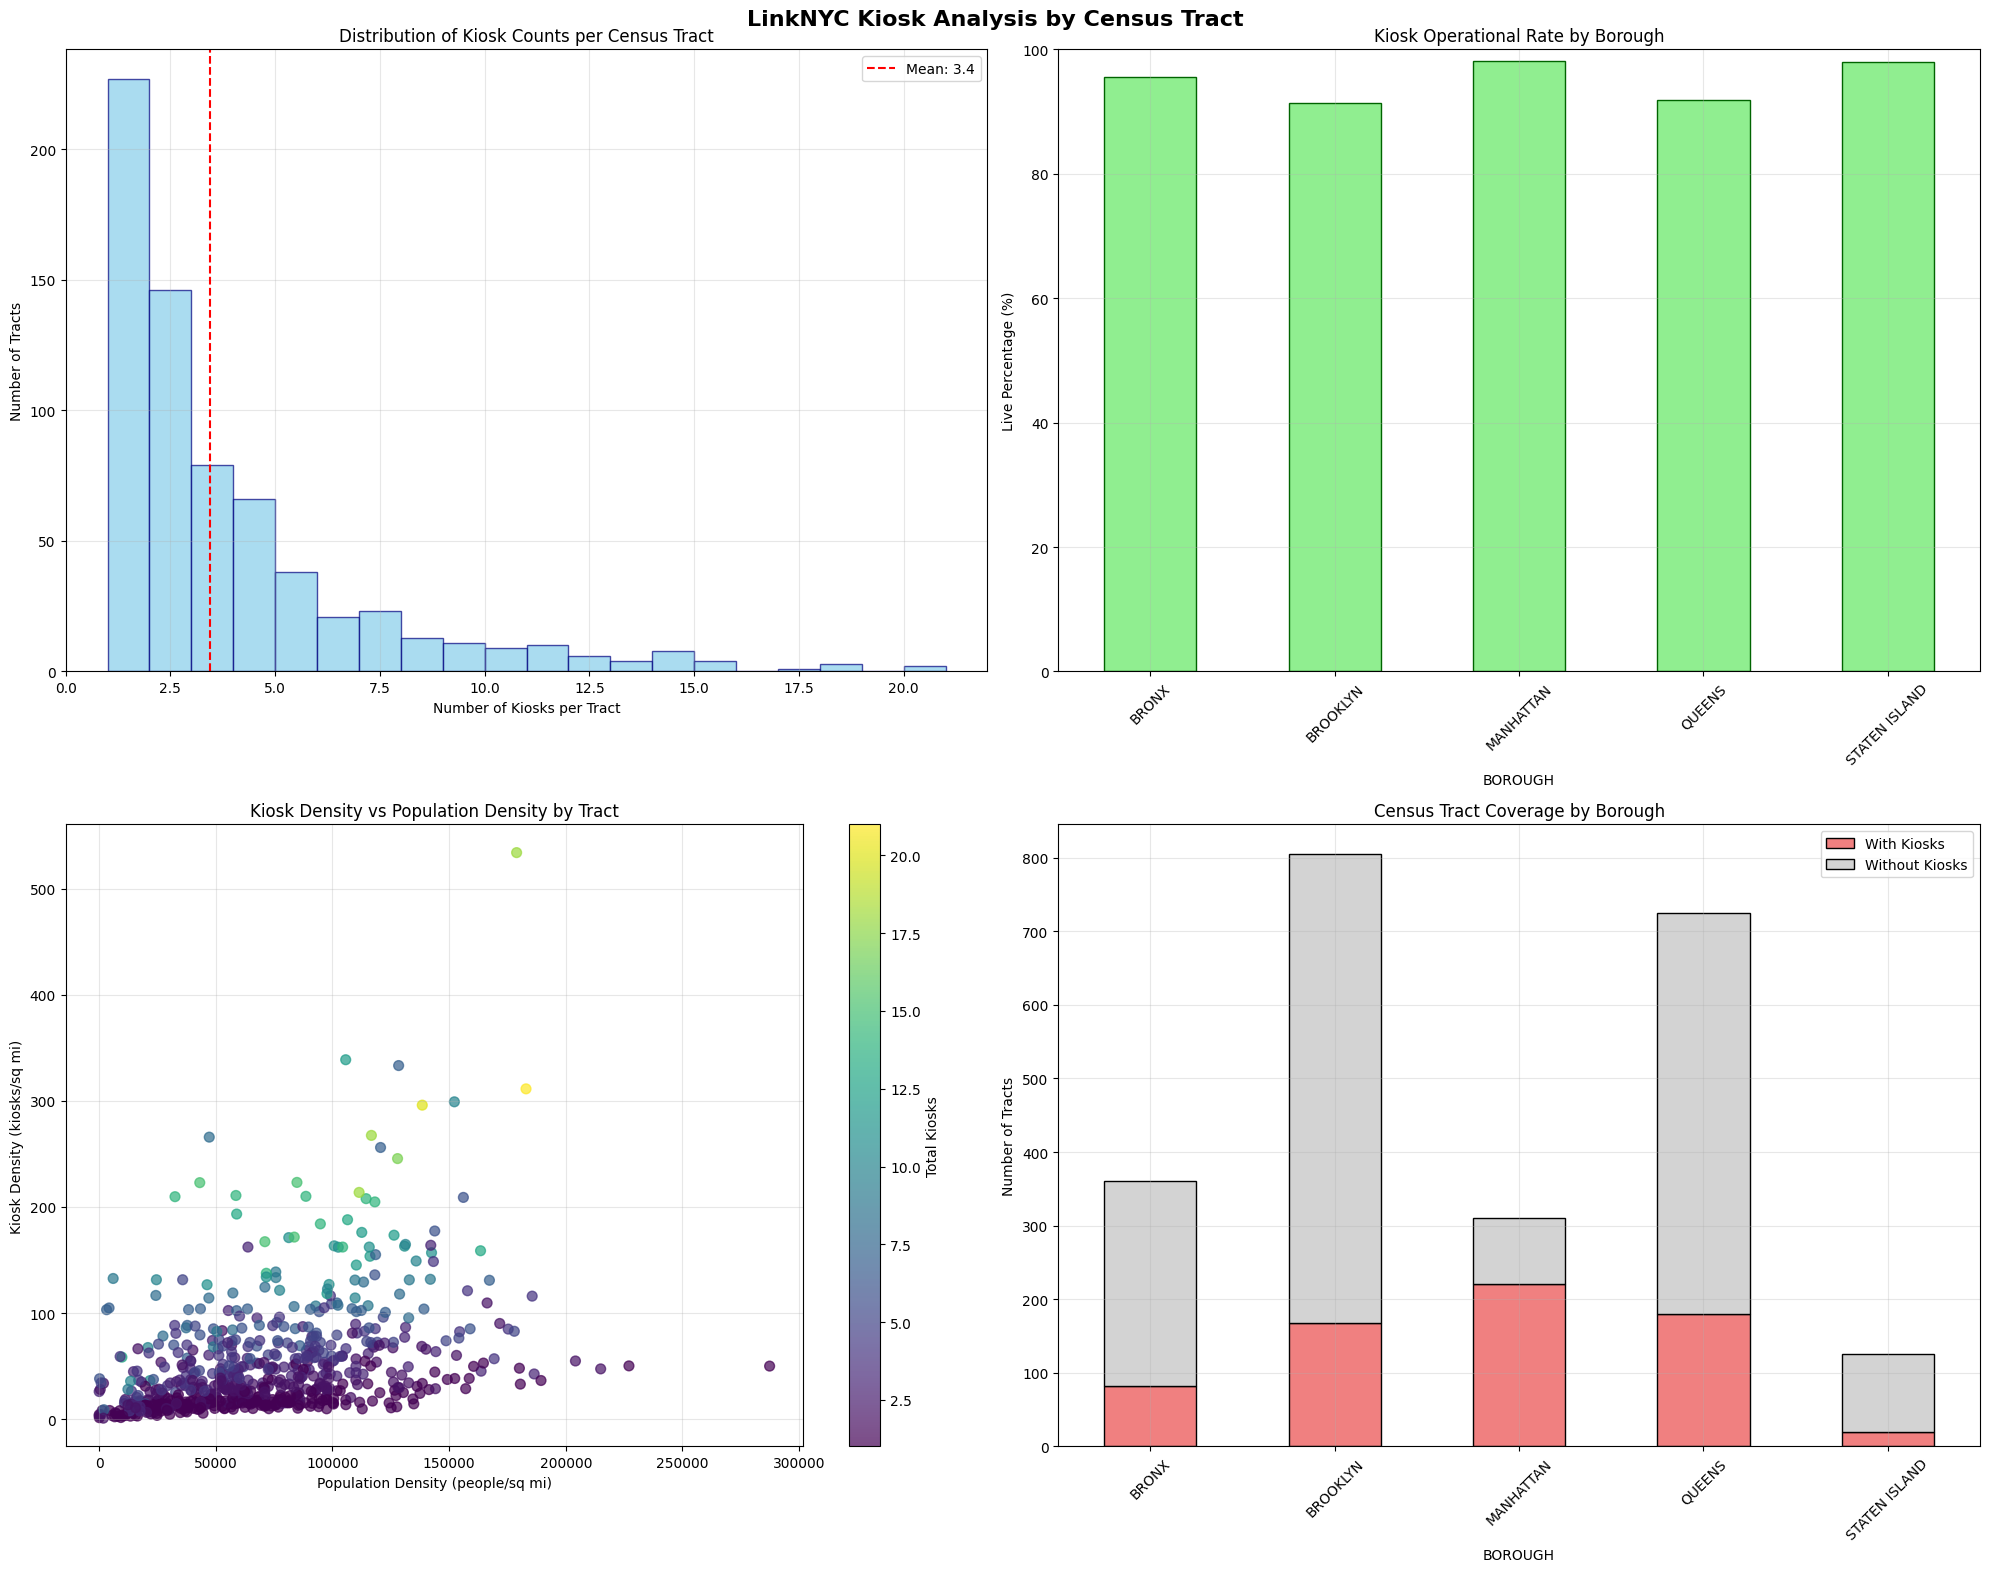

✓ Census tract visualizations completed


In [8]:
if tract_analysis is not None:
    print("Creating census tract visualizations...")
    
    # Set up the plotting area
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('LinkNYC Kiosk Analysis by Census Tract', fontsize=16, fontweight='bold')
    
    # 1. Distribution of kiosk counts per tract
    tract_kiosk_counts = tract_analysis[tract_analysis['total_kiosks'] > 0]['total_kiosks']
    axes[0,0].hist(tract_kiosk_counts, bins=20, color='skyblue', edgecolor='navy', alpha=0.7)
    axes[0,0].set_title('Distribution of Kiosk Counts per Census Tract')
    axes[0,0].set_xlabel('Number of Kiosks per Tract')
    axes[0,0].set_ylabel('Number of Tracts')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].axvline(tract_kiosk_counts.mean(), color='red', linestyle='--', 
                      label=f'Mean: {tract_kiosk_counts.mean():.1f}')
    axes[0,0].legend()
    
    # 2. Kiosk operational rates by borough
    borough_ops = tract_analysis.groupby('BOROUGH').agg({
        'total_kiosks': 'sum',
        'live_kiosks': 'sum'
    })
    borough_ops['live_rate'] = borough_ops['live_kiosks'] / borough_ops['total_kiosks'] * 100
    
    borough_ops['live_rate'].plot(kind='bar', ax=axes[0,1], color='lightgreen', edgecolor='darkgreen')
    axes[0,1].set_title('Kiosk Operational Rate by Borough')
    axes[0,1].set_ylabel('Live Percentage (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_ylim(0, 100)
    
    # 3. Relationship between population density and kiosk density
    active_tracts = tract_analysis[tract_analysis['total_kiosks'] > 0]
    scatter = axes[1,0].scatter(active_tracts['POPULATION_DENSITY'], active_tracts['kiosks_per_sqmi'], 
                              c=active_tracts['total_kiosks'], cmap='viridis', alpha=0.7, s=50)
    axes[1,0].set_title('Kiosk Density vs Population Density by Tract')
    axes[1,0].set_xlabel('Population Density (people/sq mi)')
    axes[1,0].set_ylabel('Kiosk Density (kiosks/sq mi)')
    axes[1,0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1,0], label='Total Kiosks')
    
    # 4. Tracts with vs without kiosks by borough
    tract_coverage = tract_analysis.groupby('BOROUGH').apply(
        lambda x: pd.Series({
            'With Kiosks': (x['total_kiosks'] > 0).sum(),
            'Without Kiosks': (x['total_kiosks'] == 0).sum()
        })
    )
    
    tract_coverage.plot(kind='bar', stacked=True, ax=axes[1,1], 
                       color=['lightcoral', 'lightgray'], edgecolor='black')
    axes[1,1].set_title('Census Tract Coverage by Borough')
    axes[1,1].set_ylabel('Number of Tracts')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Census tract visualizations completed")
else:
    print("✗ Cannot create visualizations without tract analysis data")

## Export Results and Summary

In [11]:
if tract_analysis is not None:
    print("Exporting results...")
    
    # Create output directory
    import os
    output_dir = '../output'
    os.makedirs(output_dir, exist_ok=True)
    
    # Export tract-level statistics to CSV
    export_cols = ['TRACT_GEOID', 'BOROUGH', 'total_kiosks', 'live_kiosks', 'live_percentage',
                  'POP20', 'LAND_AREA_SQMI', 'POPULATION_DENSITY', 'kiosks_per_sqmi', 
                  'kiosks_per_1000_pop', 'primary_kiosk_type', 'community_boards']
    
    tract_export = tract_analysis[export_cols].copy()
    export_path = os.path.join(output_dir, 'linknyc_census_tract_analysis.csv')
    tract_export.to_csv(export_path, index=False)
    
    print(f"✓ Tract analysis exported to: {export_path}")
    
    # Create summary statistics
    print("\n" + "="*70)
    print("LINKNYC CENSUS TRACT ANALYSIS SUMMARY")
    print("="*70)
    
    total_tracts = len(tract_analysis)
    tracts_with_kiosks = len(tract_analysis[tract_analysis['total_kiosks'] > 0])
    coverage_pct = (tracts_with_kiosks / total_tracts * 100)
    
    print(f"\n📊 GEOGRAPHIC COVERAGE:")
    print(f"• Total NYC Census Tracts: {total_tracts:,}")
    print(f"• Tracts with Kiosks: {tracts_with_kiosks:,} ({coverage_pct:.1f}% coverage)")
    print(f"• Total Kiosks Analyzed: {tract_analysis['total_kiosks'].sum():,}")
    print(f"• Total Live Kiosks: {tract_analysis['live_kiosks'].sum():,}")
    
    active_tracts = tract_analysis[tract_analysis['total_kiosks'] > 0]
    
    print(f"\n📈 TRACT-LEVEL METRICS:")
    print(f"• Average Kiosks per Tract (with kiosks): {active_tracts['total_kiosks'].mean():.1f}")
    print(f"• Median Kiosks per Tract: {active_tracts['total_kiosks'].median():.1f}")
    print(f"• Max Kiosks in Single Tract: {active_tracts['total_kiosks'].max()}")
    print(f"• Average Operational Rate: {active_tracts['live_percentage'].mean():.1f}%")
    
    print(f"\n🏙️ DENSITY ANALYSIS:")
    print(f"• Average Kiosk Density: {active_tracts['kiosks_per_sqmi'].mean():.1f} kiosks/sq mi")
    print(f"• Max Kiosk Density: {active_tracts['kiosks_per_sqmi'].max():.1f} kiosks/sq mi")
    print(f"• Average Per Capita: {active_tracts['kiosks_per_1000_pop'].mean():.2f} kiosks/1K pop")
    
    print(f"\n📁 OUTPUTS GENERATED:")
    print(f"• Census tract analysis CSV")
    print(f"• Interactive choropleth map")
    print(f"• Tract-level performance metrics")
    print(f"• Geographic coverage analysis")
    
    print(f"\n✅ Analysis complete! Census tract level insights provide detailed")
    print(f"   geographic understanding for urban planning and infrastructure optimization.")
    
else:
    print("✗ Cannot export results without tract analysis data")

Exporting results...
✓ Tract analysis exported to: ../output/linknyc_census_tract_analysis.csv

LINKNYC CENSUS TRACT ANALYSIS SUMMARY

📊 GEOGRAPHIC COVERAGE:
• Total NYC Census Tracts: 2,327
• Tracts with Kiosks: 671 (28.8% coverage)
• Total Kiosks Analyzed: 2,308
• Total Live Kiosks: 2,206

📈 TRACT-LEVEL METRICS:
• Average Kiosks per Tract (with kiosks): 3.4
• Median Kiosks per Tract: 2.0
• Max Kiosks in Single Tract: 21
• Average Operational Rate: 95.0%

🏙️ DENSITY ANALYSIS:
• Average Kiosk Density: 51.9 kiosks/sq mi
• Max Kiosk Density: 533.9 kiosks/sq mi
• Average Per Capita: 2.15 kiosks/1K pop

📁 OUTPUTS GENERATED:
• Census tract analysis CSV
• Interactive choropleth map
• Tract-level performance metrics
• Geographic coverage analysis

✅ Analysis complete! Census tract level insights provide detailed
   geographic understanding for urban planning and infrastructure optimization.
